# Select fastest time from multiple series

In [24]:
%matplotlib inline
import re
import sys
import os
import io
from cycler import cycler
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import LinearLocator
import pandas as pd
import lib

In [25]:
print "Numpy:", np.__version__
print "Pandas:", pd.__version__
print "Matplotlib:", matplotlib.__version__
print "Seaborn:", sns.__version__

Numpy: 1.16.4
Pandas: 0.23.4
Matplotlib: 2.2.3
Seaborn: 0.9.0


## Read logs from CSV file 

In [2]:
csv_file = "logs/mouse/dnnmark_test_composed_model_microseries_20190926/dnnmark_logs_mouse.csv"
df = pd.read_csv(csv_file)
df.head()

,env,machine,shape,algo_pref,algos,batch,time
0,"mouse\nQuadro P2000 5058 MiB\nNVDRV:410.78, C...",mouse,16_64_128,bwd-no-workspace,cudnn_cudnn_cudnn,7,4.285059
1,"mouse\nQuadro P2000 5058 MiB\nNVDRV:410.78, C...",mouse,4_512_512,bwd-no-workspace,cudnn_cudnn_cudnn,7,22.624181
2,"mouse\nQuadro P2000 5058 MiB\nNVDRV:410.78, C...",mouse,4_256_512,bwd-no-workspace,cudnn_cudnn_cudnn,7,11.581006
3,"mouse\nQuadro P2000 5058 MiB\nNVDRV:410.78, C...",mouse,16_128_128,all-fastest,cudnn_cudnn_cudnn,7,5.902930
4,"mouse\nQuadro P2000 5058 MiB\nNVDRV:410.78, C...",mouse,32_64_64,bwd-no-workspace,cudnn_cudnn_cudnn,7,10.307074


#### Functions

In [4]:
def drawGrid(ax, xstep=50, ystep=None):
    ax.grid(ls=":", alpha=.6)
#     ax.set_ylabel("time (s)")
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    minorLocatorX = MultipleLocator(xstep / 5)
    majorLocatorX = MultipleLocator(xstep)
    ax.xaxis.set_major_locator(majorLocatorX)
    ax.xaxis.set_minor_locator(minorLocatorX)
    if ystep is not None:
        minorLocatorY = MultipleLocator(ystep / 5.)
        majorLocatorY = MultipleLocator(ystep)
        ax.yaxis.set_minor_locator(minorLocatorY)
        ax.yaxis.set_major_locator(majorLocatorY)
    ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.5)
    ax.grid(which="major", ls=":", alpha=0.25, color="black")

## Plot series

Machine: mouse
Environment:
mouse
Quadro P2000  5058 MiB
NVDRV:410.78, CUDA10.0, cuDNN7.6.1.34-1
6x Intel(R) Core(TM) i5-8400 CPU @ 2.80GHz(4000.0000)


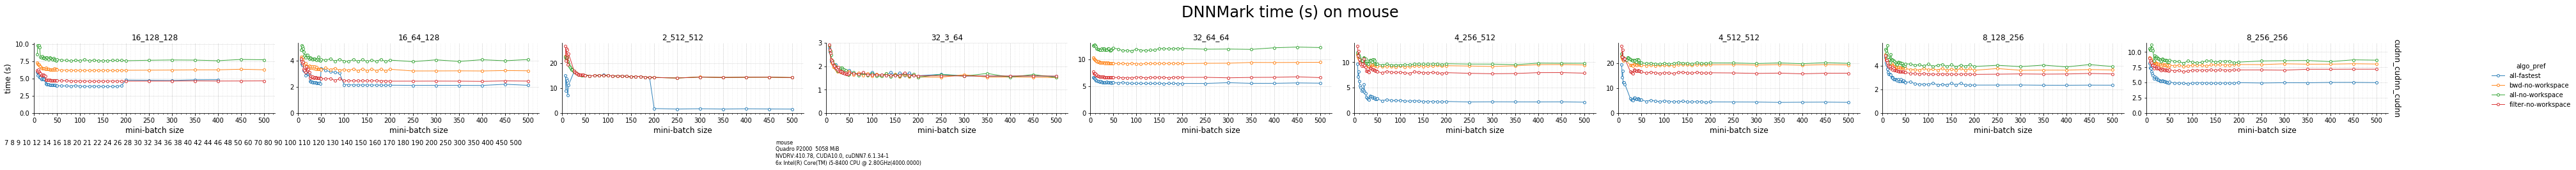

In [14]:
# Plot time per shape
for machine in df["machine"].unique():
    print "Machine: {}".format(machine)
    mlogs = df[df["machine"] == machine]
    print "Environment:"
    environment = mlogs.iloc[0]["env"]
    print environment
    fg = sns.FacetGrid(mlogs.sort_values(by=["shape", "batch"]), row="algos", col="shape", hue="algo_pref",
                       height=3, aspect=2, margin_titles=True, sharey=False)
    g = fg.map(plt.plot, "batch", "time", lw=1, alpha=0.9, ms=4, marker="o",
               fillstyle="full", markerfacecolor="#ffffff").add_legend()

    plt.subplots_adjust(top=0.7)
    g.fig.suptitle("DNNMark time (s) on {}".format(machine), fontsize=24)

    for ax_arr in np.nditer(fg.axes, flags=["refs_ok"]):
        ax = ax_arr.item()
        drawGrid(ax, xstep=50)

    [plt.setp(axg.texts, text="") for axg in g.axes.flat]
    g.set_titles(row_template='{row_name}', col_template='{col_name}', size=12)
    axes = g.axes
    for i, row in enumerate(axes):
        #     print row.shape
        for j, column in enumerate(row):
            if j == 0:
                ax = axes[i, j]
                ax.set_ylabel("time (s)", fontsize=12)
            if i == axes.shape[0] - 1:
                ax = axes[i, j]
                ax.set_xlabel("mini-batch size", fontsize=12)

    # mini-batch sizes
    batchsizes = " ".join([str(a) for a in sorted(mlogs["batch"].unique())])
    text = batchsizes
    g.fig.text(0, 0, text, ha="left", va="top", fontsize=10)

    x = 0.3  # bottom text horizontal position
    g.fig.text(x, 0, environment, ha="left", va="top", fontsize=8)

    
    plt.show()

In [17]:
df_ = df[["machine", "shape", "algo_pref", "algos", "batch", "time"]]
df_.head()

,machine,shape,algo_pref,algos,batch,time
0,mouse,16_64_128,bwd-no-workspace,cudnn_cudnn_cudnn,7,4.285059
1,mouse,4_512_512,bwd-no-workspace,cudnn_cudnn_cudnn,7,22.624181
2,mouse,4_256_512,bwd-no-workspace,cudnn_cudnn_cudnn,7,11.581006
3,mouse,16_128_128,all-fastest,cudnn_cudnn_cudnn,7,5.902930
4,mouse,32_64_64,bwd-no-workspace,cudnn_cudnn_cudnn,7,10.307074


In [33]:
df.dtypes

env           object
machine       object
shape         object
algo_pref     object
algos         object
batch          int64
time         float64
dtype: object

In [60]:
df_ = df[["machine", "shape", "algos", "algo_pref", "batch", "time"]]
df_new = pd.DataFrame(columns=["machine", "shape", "algos", "algo_pref", "batch", "time"])
for group_name, group in df_.groupby(by=["machine","shape","algos","batch"]):
#     display(group.head())    
    min_times = np.min(group["time"].values)
    fastest_series = [
        group.iloc[0]["machine"], # machine
        group.iloc[0]["shape"], # shape
        group.iloc[0]["algos"],
        "fastest",
        group.iloc[0]["batch"], # batch
        min_times
        ]
#     print fastest_series,df_new.shape[0]
    df_new.loc[df_new.shape[0]] = fastest_series
    
# df_new.sort_values(by=["shape","batch"]).head(9)
df_new.head()

,machine,shape,algos,algo_pref,batch,time
0,mouse,16_128_128,cudnn_cudnn_cudnn,fastest,7,5.902930
1,mouse,16_128_128,cudnn_cudnn_cudnn,fastest,8,5.482243
2,mouse,16_128_128,cudnn_cudnn_cudnn,fastest,9,5.931763
3,mouse,16_128_128,cudnn_cudnn_cudnn,fastest,10,5.669238
4,mouse,16_128_128,cudnn_cudnn_cudnn,fastest,12,5.190943


In [61]:
df_m = pd.concat([df_new, df_],axis=0,sort=True)
# df_m.head()
df_m.sort_values(by=["shape","algos","batch"]).head(10)

,algo_pref,algos,batch,machine,shape,time
0,fastest,cudnn_cudnn_cudnn,7,mouse,16_128_128,5.902930
3,all-fastest,cudnn_cudnn_cudnn,7,mouse,16_128_128,5.902930
7,bwd-no-workspace,cudnn_cudnn_cudnn,7,mouse,16_128_128,7.360737
16,all-no-workspace,cudnn_cudnn_cudnn,7,mouse,16_128_128,8.512469
32,filter-no-workspace,cudnn_cudnn_cudnn,7,mouse,16_128_128,6.193538
1,fastest,cudnn_cudnn_cudnn,8,mouse,16_128_128,5.482243
47,bwd-no-workspace,cudnn_cudnn_cudnn,8,mouse,16_128_128,7.144792
56,filter-no-workspace,cudnn_cudnn_cudnn,8,mouse,16_128_128,5.976194
65,all-no-workspace,cudnn_cudnn_cudnn,8,mouse,16_128_128,9.861674
66,all-fastest,cudnn_cudnn_cudnn,8,mouse,16_128_128,5.482243


Machine: mouse


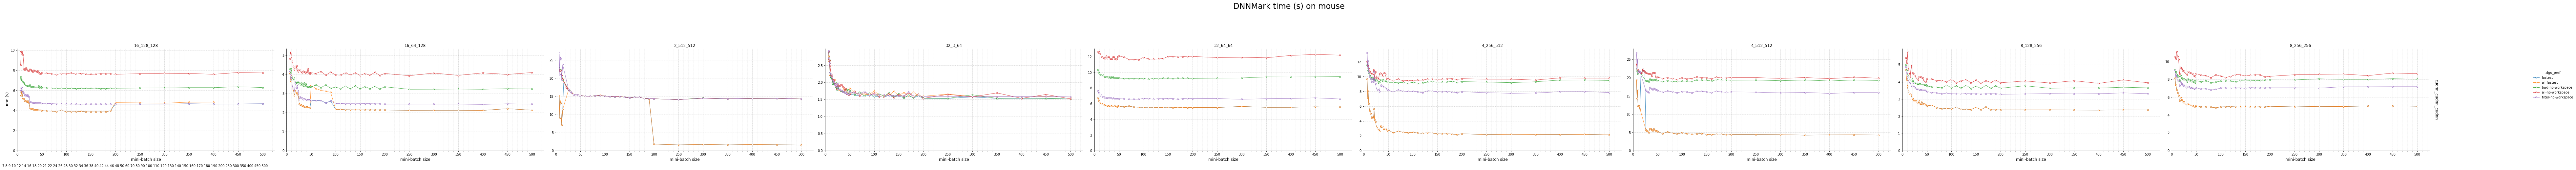

In [67]:
# Plot time per shape
for machine,mlogs in df_m.groupby(["machine"]):
    print "Machine: {}".format(machine)
    fg = sns.FacetGrid(mlogs.sort_values(by=["shape", "batch"]), row="algos", col="shape", hue="algo_pref",
                       height=7, aspect=1.7, margin_titles=True, sharey=False)
    g = fg.map(plt.plot, "batch", "time", lw=1, alpha=0.9, ms=4, marker="o",
               fillstyle="full", markerfacecolor="#ffffff").add_legend()

    plt.subplots_adjust(top=0.7)
    g.fig.suptitle("DNNMark time (s) on {}".format(machine), fontsize=24)

    for ax_arr in np.nditer(fg.axes, flags=["refs_ok"]):
        ax = ax_arr.item()
        drawGrid(ax, xstep=50)

    [plt.setp(axg.texts, text="") for axg in g.axes.flat]
    g.set_titles(row_template='{row_name}', col_template='{col_name}', size=12)
    axes = g.axes
    for i, row in enumerate(axes):
        #     print row.shape
        for j, column in enumerate(row):
            if j == 0:
                ax = axes[i, j]
                ax.set_ylabel("time (s)", fontsize=12)
            if i == axes.shape[0] - 1:
                ax = axes[i, j]
                ax.set_xlabel("mini-batch size", fontsize=12)

    # mini-batch sizes
    batchsizes = " ".join([str(a) for a in sorted(mlogs["batch"].unique())])
    text = batchsizes
    g.fig.text(0, 0, text, ha="left", va="top", fontsize=10)

    plt.show()